# Loss Landscape-Based Dataset Pruning

## Overview

This notebook implements and applies a novel loss landscape-based dataset pruning algorithm to create optimally selected training subsets. The methodology leverages geometric properties of loss landscape surfaces to identify the information rich samples. These samples are used to train models. The results can be found in notebook `NBE10`.

### Objectives
- Apply the loss landscape pruning methodology established in NBT7
- Generate pruned training subsets from the iteration 1 active learning dataset (630 double perovskites samples)

### Methodological Innovation
- **Loss Landscape-Guided Selection**: Novel approach using optimization surface geometry for sample selection
- **Approximate Subset Algorithm**: Efficient algorithm for large-scale dataset pruning
- **Clustering-Based Optimization**: K-means clustering to balance computational efficiency with selection quality
- **Reconstruction Quality Metrics**: Mean Absolute Error (MAE) assessment of landscape approximation

### Experimental Design
- **Source Dataset**: Iteration 1 self-training dataset from active learning (630 samples)
- **Target Property**: Formation energy (dHf) prediction for crystalline materials
- **Pruning Range**: Multiple subset sizes from 30 to 630 samples (30-sample increments)
- **Comparison Framework**: Loss landscape pruning vs random sampling
- **Quality Assessment**: MAE of average loss landscape reconstruction

## 1. Environment Setup and Algorithm Dependencies

### Required Libraries and Modules
Setting up the computational environment for loss landscape-based dataset pruning:

### Custom Algorithm Import
The `approximate_subset_auto_k` function represents the core algorithm of this work:
- **Clustering-Based Selection**: Uses K-means clustering for efficient subset identification
- **Quality Optimization**: Balances computational efficiency with selection quality
- **Convergence Criteria**: MAE threshold and iteration limits for robust performance
- **Reproducible Results**: Random state control for consistent algorithm behavior


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from src.LL_pruning import approximate_subset_auto_k
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="'force_all_finite' was renamed to 'ensure_all_finite'")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")


## 2. Loss Landscape Data Loading and Integration

### Pre-computed Loss Landscape Import
Loading loss landscape data computed for the iteration 1 self-training dataset:

- **Model Context**: Directly trained on the 630 double perovskite samples (no domain adaptation)
- **Hessian eigenvector**: Hessian eigenvectors computed from 250 low error samples
- **Loss landscape**: Loss landscape for each of the 630 samples



In [ ]:
folders = [r'computed_loss_landscapes\self_train_data_ON_EIGVEC_iter_1_self_train_250_lowest_error']

In [ ]:
loss_function_dicts = []
for folder in folders:
    with open(os.path.join(folder,'processed_loss_function_dict.pkl'), 'rb') as file:
        loss_function_dicts.append(pickle.load(file))

# Merge all dictionaries from loss_function_dicts into a single dictionary
merged_loss_function_dict = {}
for d in loss_function_dicts:
    for key, value in d.items():
        if key not in merged_loss_function_dict:
            merged_loss_function_dict[key] = value
        else:
            # If key exists, update/append values
            merged_loss_function_dict[key].update(value)

# Update the loss_function_dict to use merged version
loss_function_dict = merged_loss_function_dict

with open(os.path.join(folders[0],'feat_sample_df.pkl'), 'rb') as file:
    feat_sample_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_composition_df.pkl'), 'rb') as file:
    feat_sample_composition_df = pickle.load(file)

with open(os.path.join(folders[0],'feat_sample_structure_df.pkl'), 'rb') as file:
    feat_sample_structure_df = pickle.load(file)

sample_dict = {
    'feat_sample_df': feat_sample_df,
    'feat_sample_composition_df': feat_sample_composition_df,
    'feat_sample_structure_df': feat_sample_structure_df}

combined_dict = {**sample_dict, **loss_function_dict}

## 3. Loss Landscape-Based Pruning Algorithm Implementation

### Systematic Subset Size Evaluation
Implementing the core pruning algorithm across multiple dataset sizes to establish optimal pruning strategies:

#### Algorithm Parameters
- **Cluster Range**: Testing 30 to 630 clusters in 30-sample increments
- **Convergence Criteria**: MAE threshold of 1×10⁻⁵ for landscape reconstruction quality
- **Maximum Iterations**: 5,000 iterations to ensure algorithm convergence
- **Reproducibility**: Fixed random state (seed=0) for consistent results

#### Performance Metrics Collection
For each subset size, the algorithm records:
- **Selected Sample Indices**: Specific samples chosen by the loss landscape algorithm
- **Reconstruction MAE**: Quality of average loss landscape approximation
- **Subset Size**: Number of samples in the pruned dataset

### Quality Assessment Framework
The Mean Absolute Error (MAE) of loss landscape reconstruction serves as the primary quality metric:
- **Lower MAE**: Better preservation of original optimization surface characteristics

In [ ]:
landscape_array_1 = loss_function_dict['train_630_data_ON_EIGVEC_iter_1_self_train_250_lowest_error_mse']['train_630_data_ON_EIGVEC_iter_1_self_train_250_lowest_error_mse_loss_landscape_array']
property_1 = combined_dict['feat_sample_df']['jid'].copy()
landscape_list = landscape_array_1.to_list()
samples = np.stack(landscape_list, axis=0)

### Algorithm Performance Visualization
Comprehensive analysis of the pruning algorithm's effectiveness across different subset sizes:

#### Performance Curve Analysis
- **X-axis**: Number of samples in the pruned subset (30-630 range)
- **Y-axis**: Mean Absolute Error of average loss landscape reconstruction

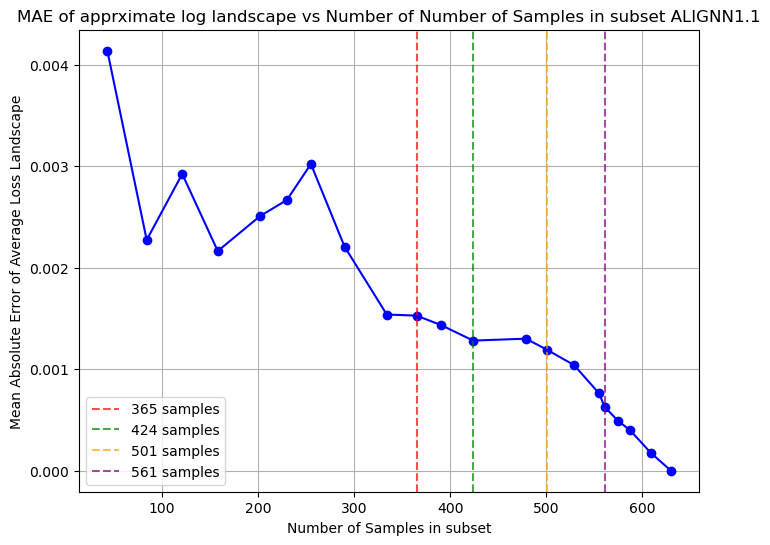

In [30]:
# Test different numbers of clusters and record MAE
n_clusters_range = range(30,631,30)
results_data = {'n_clusters': [], 'mae': [], 'selected_indices': [], 'n_samples': []}

for n in n_clusters_range:
    selected_idxs, _, _, mae, n_clusters = approximate_subset_auto_k(
        samples,
        n_clusters=n,
        mae_threshold=1e-5,
        max_iters=5000,
        random_state=0
    )
    results_data['n_clusters'].append(n)
    results_data['mae'].append(mae)
    results_data['selected_indices'].append(list(selected_idxs))
    results_data['n_samples'].append(len(selected_idxs))

# Create DataFrame with results
results_df = pd.DataFrame(results_data)

# Plot n_clusters vs MAE
plt.figure(figsize=(8, 6))
plt.plot(results_df['n_samples'], results_df['mae'], 'bo-')
plt.xlabel('Number of Samples in subset')
plt.ylabel('Mean Absolute Error of Average Loss Landscape')
plt.title('MAE of apprximate log landscape vs Number of Number of Samples in subset ALIGNN1.1')
plt.grid(True)

# Add vertical lines for strategic subset sizes
plt.axvline(x=365, color='red', linestyle='--', alpha=0.7, label='365 samples')
plt.axvline(x=424, color='green', linestyle='--', alpha=0.7, label='424 samples')
plt.axvline(x=501, color='orange', linestyle='--', alpha=0.7, label='501 samples')
plt.axvline(x=561, color='purple', linestyle='--', alpha=0.7, label='561 samples')
plt.legend()

plt.show()

## 4. Comparative Analysis: Loss Landscape vs Random Sampling

### Random Sampling Baseline Generation
Creating random sampling baselines for comprehensive comparison with the loss landscape-based approach:

#### Random Selection Protocol
- **Reproducible Sampling**: Fixed random seed (42) for consistent random baseline generation
- **Sample Size Matching**: Each random subset matches the corresponding LL-pruned subset size

In [28]:
# Add a column for selected formulas by mapping selected indices to property_1 values
results_df['pruned_selected_formulas'] = results_df['selected_indices'].apply(lambda x: property_1.iloc[x].tolist())

# Create random indices for each row based on n_samples
np.random.seed(42)  # Set random seed for reproducibility
results_df['random_selected_indices'] = results_df['n_samples'].apply(
    lambda n: np.random.choice(
        np.linspace(0, len(samples)-1, len(samples), dtype=int),
        size=n,
        replace=False
    ).tolist()
)

# Add column for random formulas by mapping random indices to property_1 values 
results_df['random_selected_formulas'] = results_df['random_selected_indices'].apply(
    lambda x: property_1.iloc[x].tolist()
)

results_df[results_df['n_clusters'].isin([300, 360, 420, 510])]

,n_clusters,mae,selected_indices,n_samples,pruned_selected_formulas,random_selected_indices,random_selected_formulas
9,300,0.001527,"[0, 1, 2, 4, 5, 7, 11, 13, 14, 15, 16, 17, 18,...",365,"[ZnTlLiPtF6, CaEuCsTlI6, LiCuRbHgF6, Cu2CrPbCl...","[401, 165, 80, 338, 142, 138, 607, 364, 622, 3...","[LiSnNaCdI6, ZnTlCsPbI6, NaMnCdCsBr6, AsAuHg2C..."
11,360,0.001281,"[0, 1, 2, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, ...",424,"[ZnTlLiPtF6, CaEuCsTlI6, LiCuRbHgF6, Cu2CrPbCl...","[315, 129, 370, 90, 532, 531, 608, 59, 284, 35...","[Cu2CaCrBr6, NaCsZnSnBr6, CsPbSnHgF6, SnTlMgCu..."
13,420,0.001190,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15,...",501,"[ZnTlLiPtF6, CaEuCsTlI6, LiCuRbHgF6, LiSrCaAuI...","[93, 335, 447, 235, 69, 158, 127, 246, 143, 60...","[NaRbCuSnBr6, LiNaCuSnBr6, CaCuPtTlF6, SrAuBeH..."
16,510,0.000628,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",561,"[ZnTlLiPtF6, CaEuCsTlI6, LiCuRbHgF6, LiSrCaAuI...","[278, 361, 25, 343, 452, 244, 138, 107, 132, 3...","[NaTlSn2Cl6, SrPbLiAgCl6, FeCsNa2Br6, CuHgNaCs..."


### Results Summary and Subset Selection
The filtered results table reveals selected pruned dataset for subsquent model training:

####  Pruning Levels
- **365 Samples**
- **424 Samples**
- **501 Samples**
- **561 Samples**

#### Methodological Outputs
Each pruning level provides:
- **Reconstruction Quality**: MAE values indicating landscape preservation fidelity
- **Selected Sample Lists**: Specific material JIDs chosen by the LL algorithm
- **Random Baselines**: Corresponding random selections for comparative evaluation
